In [4]:
# Install required libraries
!pip install transformers torchmetrics

# Import necessary libraries
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from transformers import SwinForImageClassification, SwinConfig
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm
from collections import defaultdict

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths to our dataset
train_path = '/content/drive/My Drive/Smartphone-Based Air Pollution Image Dataset (SAPID)/Smartphone-Based Air Pollution Image Dataset (SAPID)/train'
valid_path = '/content/drive/My Drive/Smartphone-Based Air Pollution Image Dataset (SAPID)/Smartphone-Based Air Pollution Image Dataset (SAPID)/val'
test_path = '/content/drive/My Drive/Smartphone-Based Air Pollution Image Dataset (SAPID)/Smartphone-Based Air Pollution Image Dataset (SAPID)/test'


# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets
train_ds = datasets.ImageFolder(train_path, transform=transform)
valid_ds = datasets.ImageFolder(valid_path, transform=transform)
test_ds = datasets.ImageFolder(test_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=20, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=20, shuffle=False)

# Initialize the Swin Transformer model
num_classes = len(train_ds.classes)
config = SwinConfig.from_pretrained('microsoft/swin-tiny-patch4-window7-224', num_labels=num_classes)
model = SwinForImageClassification.from_pretrained('microsoft/swin-tiny-patch4-window7-224', config=config, ignore_mismatched_sizes=True)

# Replace the classification head with a new one matching your number of classes
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# Training function
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for inputs, labels in tqdm(loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)
    return avg_loss, accuracy

# Per-class evaluation function
def evaluate_per_class(model, loader, criterion, device):
    model.eval()
    correct_predictions = defaultdict(int)
    total_samples = defaultdict(int)

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating per class"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits
            _, predicted = torch.max(outputs, 1)

            for pred, true_label in zip(predicted, labels):
                if pred == true_label:
                    correct_predictions[true_label.item()] += 1
                total_samples[true_label.item()] += 1

    accuracy_per_class = {class_idx: correct_predictions[class_idx] / total_samples[class_idx] for class_idx in correct_predictions}
    return accuracy_per_class

# Training loop with early stopping
num_epochs = 20
early_stop_patience = 3
best_valid_loss = float('inf')
epochs_since_improvement = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training phase
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)

    # Validation phase
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion, device)
    valid_accuracy_per_class = evaluate_per_class(model, valid_loader, criterion, device)

    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    # Early stopping check
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement == early_stop_patience:
        print("Early stopping triggered")
        break

    scheduler.step()

# Evaluate on the test set
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save the trained model
#torch.save(model.state_dict(), '/content/drive/Shared with me/Smartphone-Based Air Pollution Image Dataset (SAPID)/models/my_swin_model.pth')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/5 [00:00<?, ?it/s]

Training Loss: 0.8230, Training Accuracy: 0.6533
Validation Loss: 0.4097, Validation Accuracy: 0.8526
Epoch 2/20


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/5 [00:00<?, ?it/s]

Training Loss: 0.2268, Training Accuracy: 0.9213
Validation Loss: 0.2297, Validation Accuracy: 0.9368
Epoch 3/20


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/5 [00:00<?, ?it/s]

Training Loss: 0.0749, Training Accuracy: 0.9827
Validation Loss: 0.1728, Validation Accuracy: 0.9368
Epoch 4/20


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/5 [00:00<?, ?it/s]

Training Loss: 0.0274, Training Accuracy: 0.9960
Validation Loss: 0.1752, Validation Accuracy: 0.9263
Epoch 5/20


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/5 [00:00<?, ?it/s]

Training Loss: 0.0205, Training Accuracy: 0.9947
Validation Loss: 0.1784, Validation Accuracy: 0.9474
Epoch 6/20


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/5 [00:00<?, ?it/s]

Training Loss: 0.0178, Training Accuracy: 0.9960
Validation Loss: 0.2368, Validation Accuracy: 0.9579
Early stopping triggered


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.1157, Test Accuracy: 0.9579


RuntimeError: Parent directory /content/drive/Shared with me/Smartphone-Based Air Pollution Image Dataset (SAPID)/models does not exist.

In [5]:

torch.save(model.state_dict(), '/content/drive/My Drive/Smartphone-Based Air Pollution Image Dataset (SAPID)/models/my_swin_model.pth')

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.1157
Test Accuracy: 0.9579
 Precision: 0.9589
 Recall: 0.9579
 F1 Score: 0.9579


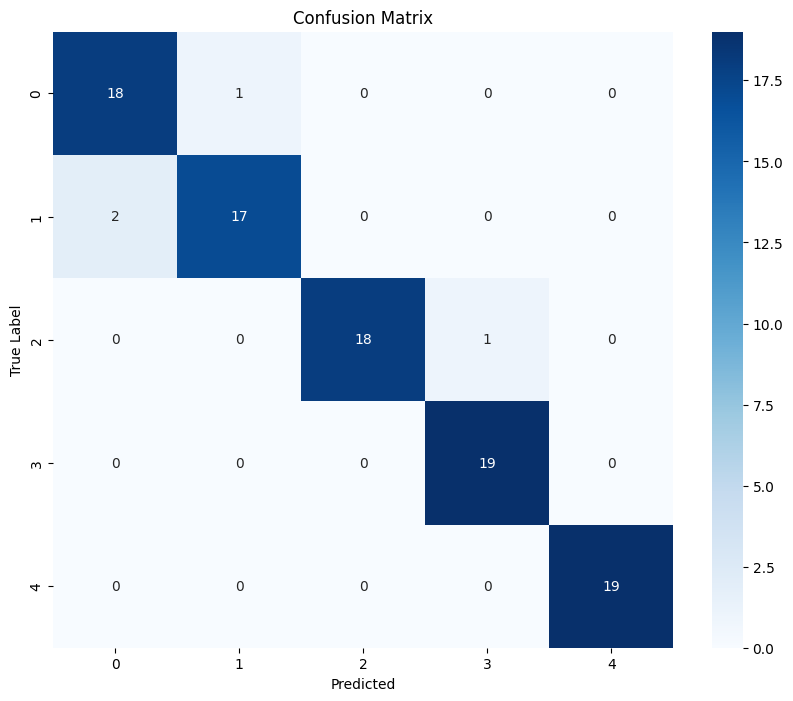

In [6]:
import torch
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)

    # Compute metrics
    precision = precision_score(all_true_labels, all_predictions, average='macro')
    recall = recall_score(all_true_labels, all_predictions, average='macro')
    f1 = f1_score(all_true_labels, all_predictions, average='macro')

    # Compute confusion matrix
    conf_mat = confusion_matrix(all_true_labels, all_predictions)

    return avg_loss, accuracy, precision, recall, f1, conf_mat

# Evaluate on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1, conf_mat = evaluate(model, test_loader, criterion, device)

# Print the metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f" Precision: {test_precision:.4f}")
print(f" Recall: {test_recall:.4f}")
print(f" F1 Score: {test_f1:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


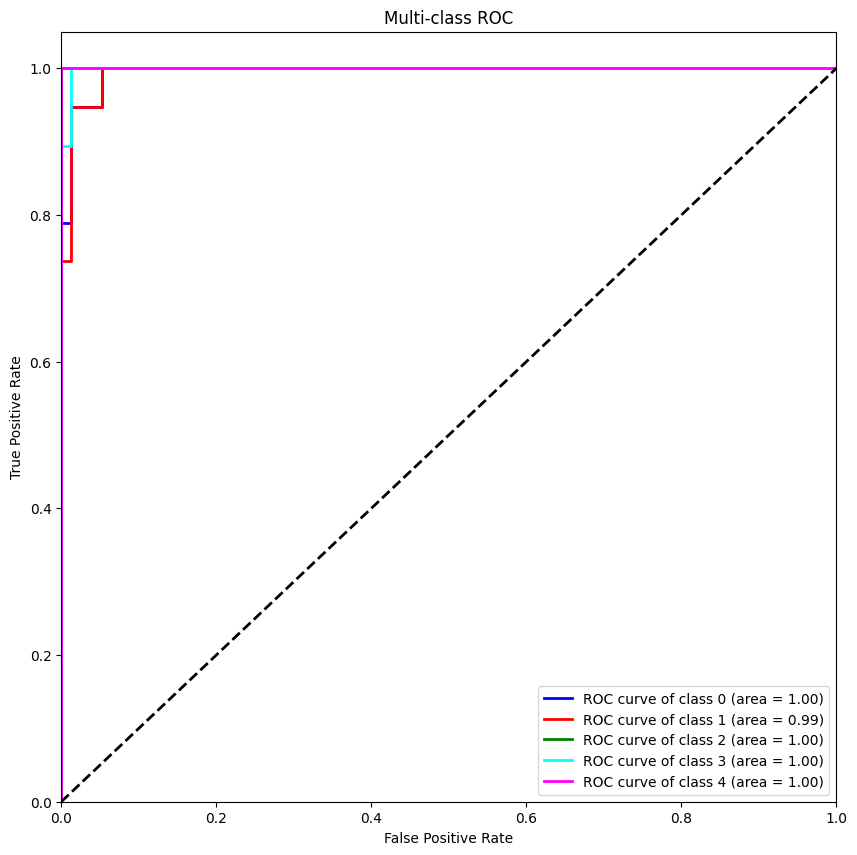

In [8]:
from itertools import cycle # Import the cycle function from itertools
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def evaluate_and_get_predictions(model, loader, device, n_classes):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).logits
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            all_preds.append(probabilities.cpu().numpy())
            all_true.append(labels.cpu().numpy())

    # Binarize the labels
    all_true_bin = label_binarize(np.concatenate(all_true), classes=range(n_classes))
    return all_true_bin, np.concatenate(all_preds)

# Get the test data predictions and true labels
n_classes = len(train_ds.classes)
y_test_bin, y_score = evaluate_and_get_predictions(model, test_loader, device, n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown'])
plt.figure(figsize=(10, 10))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()
